## Load libraries and necessary data files

In [7]:
library(data.tree)
library(data.table)
load('../data/mutation_type_pd.rda')

In [8]:
names(pdfinal) <- c('P_driver','P_passenger','P_null')
pdfinal

P_driver P_passenger      P_null 
0.001094647 0.018984124 0.979921230

In [9]:
birthrate <- function(node, type, sd, sp) {
        nd <- 0; np <- 0
        switch(type,
            { b <- ((1+sd)^(node$nd+1))/((1+sp)^(node$np  )); nd <- 1 },
            { b <- ((1+sd)^(node$nd  ))/((1+sp)^(node$np+1)); np <- 1 },
            { b <- node$B }
        )
            
        return(list(b,nd,np))
            
}

In [55]:

maybeTranspose <- function(node, sd, sp) {

    if (node$B==0){ # if the birth rate of the clone is zero, skip the node
        return()
    }
    
    # increase the number of cells by the existing number * the birth rate
    # decrease by the existing number * the death rate
    nc <- max(tail(node$ncells,n=1) + round(tail(node$ncells,n=1)*node$B) - round(tail(node$ncells,n=1)*(tail(N,n=1)/N0)), 0)
    
    # sample from binomial distribution for number of transpositions
    if (nc < 4.2e9) {ntrans <- rbinom(1,nc,mu)} # rbinom() fails for large n
    else {ntrans <- nc*mu} # If n is too large, use the expected number of events (mean of distribution)
    if (ntrans > 0) {
        
        nc <- nc-ntrans
        types <- sample(sample(1:3,ntrans,replace=TRUE,prob=pdfinal)) # sample mutation types from pdfinal
        for (i in 1:ntrans) {
            l<<-l+1
            tmp <- birthrate(node,types[i],sd,sp)
            node$AddChild(l, ncells=1, B=tmp[[1]], nd=node$nd+tmp[[2]], np=node$np+tmp[[3]])
        }
        
    }   
    node$ncells <- append(node$ncells,nc)

}

### Define parameters

In [122]:
#--- Set simulation parameters
N0 <- 100           # Initial number of cells in root clone
mu <- 0.2           # Probability of transposition / timestep of a single cell

NT <- 100            # Number of time steps

### Clone tree creation

elapsed 
  9.138

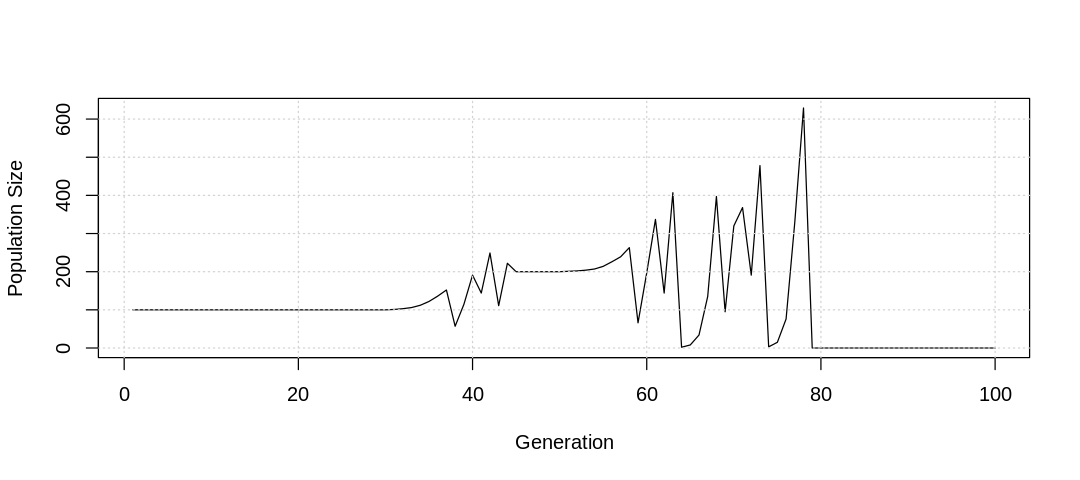

In [123]:
l<-1 # Clone counter

N <- N0 # total population size

CellPop <- Node$new(1) # Initialize data.tree as single node

CellPop$ncells <- c(N0) # Set initial number of cells of clone
CellPop$B <-  1         # Set initial birth rate of clone
CellPop$np <- 0         # Set initial number of drivier mutations
CellPop$nd <- 0         # Set initial number of passenger mutations

ptm <- proc.time()
for (i in 2:NT) {

    t <- Traverse(CellPop,traversal='pre-order',filterFun=function(x) tail(x$ncells,n=1) > 0)    
    lapply(t,maybeTranspose,.1,.001)

    if (CellPop$totalCount==1) {
        N <- append(N, tail(CellPop$ncells,n=1))
    } else {
        N <- append(N,sum(vapply(CellPop$Get('ncells'),tail,n=1L,FUN.VALUE = numeric(1))))
    }
    
}
(proc.time() - ptm)[3]

# print(CellPop,'ncells','B')
# sum(vapply(CellPop$Get('ncells'),tail,n=1L,FUN.VALUE = numeric(1)))
# CellPop$Get('ncells')
options(repr.plot.width=9, repr.plot.height=4)
plot(N,type='l',xlab='Generation',ylab='Population Size'); grid()

In [121]:
# See what proportion of the nodes are empty
test <- vapply(CellPop$Get('ncells'),tail,n=1L,FUN.VALUE = numeric(1))
length(which(test==0))/CellPop$totalCount

[1] 1